# Sentiment Analysis with Deep Learning using BERT

## Exploratory Data Analysis and Preprocessing

In [2]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import nltk 
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import BlanklineTokenizer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import string
import re
from nltk.tokenize import word_tokenize
import gensim
from keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer 
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/home/Tweets.csv')
df.head()
ll = list(df.airline)


(14640, 15)
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Total airline reviews:  14640


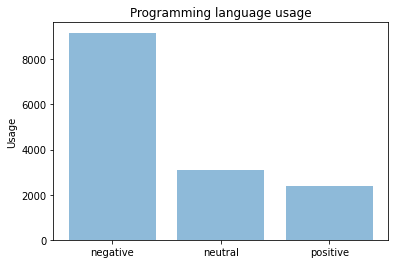

In [4]:
print(df.shape)
print(df.airline_sentiment.value_counts())
print("\n")
print("Total airline reviews: ", len(df))

import matplotlib.pyplot as plt

myfig = plt.figure()
objects = ('negative', 'neutral', 'positive')
y_pos = np.arange(len(objects))
performance = [9178, 3099, 2363]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()


In [5]:
# get unique labels
possible_labels = df.airline_sentiment.unique()
print(possible_labels)

# give label a number
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

print(label_dict)

# add column name label with appropriate label value
df['label'] = df.airline_sentiment.replace(label_dict)
df.head()

['neutral' 'positive' 'negative']
{'neutral': 0, 'positive': 1, 'negative': 2}


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,label
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),0
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),2
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),2


In [7]:
# preprocess the text
def preprocess(message):

    # Lowercase the twit message
    text = message.lower()
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    # Replace usernames with a space. The usernames are any word that starts with @.
    text = text.replace('@', " ") 
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        

messages = list(df.text)

# Process for all messages
preprocessed_ = [preprocess(message) for message in tqdm(messages)]

preprocessed = []
from datetime import datetime

for i,date in enumerate(df.tweet_created):
  d = date.split(" ")
  tweet = d[0] + " " + preprocessed_[i]
  preprocessed.insert(i, tweet)

print("Length of preprocessed text reviews: ", len(preprocessed)) 



Length of preprocessed text reviews:  14640


In [8]:

def tokenizer(text):
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized



In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Create vocab
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenizer(message) # Use option 3
        corpus.extend(tokens)
    print("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    print("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    print("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["will", "report", "reporting", "market", "stock", "share"])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

    return vocab


# LSTM Model with 2 hidden layers 
#  embed_size=512, lstm_size=1024, dense_size=512

In [10]:
from torch import nn

# LSTM Model
class LstmTextClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_matrix, embed_size, lstm_size, dense_size, output_size, lstm_layers, dropout):
    """
    Initialize the model
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.lstm_size = lstm_size
    self.dense_size = dense_size
    self.output_size = output_size
    self.lstm_layers = lstm_layers
    self.dropout = dropout

    self.embedding = nn.Embedding(vocab_size, embed_size, _weight=embedding_matrix)
    #self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=0.1, batch_first=False)
    self.dropout = nn.Dropout(0.1)
    self.fc1 = nn.Linear(lstm_size, dense_size)
    self.dropout =  nn.Dropout(0.2)
    self.fc2 = nn.Linear(dense_size, dense_size)
    self.dropout = nn.Dropout(0.4)                  # increasing drop out with  hidden layers 
    self.fc3 = nn.Linear(dense_size, output_size)

    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
    return hidden

  def forward(self, nn_input_text, hidden_state):
    """
    Perform a forward pass of the model on nn_input
    """
    batch_size = nn_input_text.size(0)
    nn_input_text = nn_input_text.long()
    embeds = self.embedding(nn_input_text)
    lstm_out, hidden_state = self.lstm(embeds, hidden_state)
    lstm_out = lstm_out[-1,:,:]
    lstm_out = self.dropout(lstm_out)
    dense_out = self.fc1(lstm_out)
    out1 = self.fc2(dense_out)
    out = self.fc3(dense_out)
    # Softmax
    logps = self.softmax(out)
    return logps, hidden_state
      
     
# Define LSTM Tokenizer
def tokenizer_lstm(X, vocab, seq_len, padding):
  X_tmp = np.zeros((len(X), seq_len), dtype=np.int64)
  for i, text in enumerate(X):
    tokens = tokenizer(text) 
    token_ids = [vocab[word] for word in tokens]
    end_idx = min(len(token_ids), seq_len)
    start_idx = max(seq_len - len(token_ids), 0)
    X_tmp[i,start_idx:] = token_ids[:end_idx]

  return torch.tensor(X_tmp, dtype=torch.int64)

In [24]:
# reference
# https://towardsdatascience.com/lstm-vs-bert-a-step-by-step-guide-for-tweet-sentiment-analysis-ced697948c47

!pip install transformers
from transformers import AdamW, get_linear_schedule_with_warmup

     |████████████████████████████████| 2.1MB 9.1MB/s 
     |████████████████████████████████| 3.3MB 55.6MB/s 
     |████████████████████████████████| 901kB 55.8MB/s 


# creating data loader

In [13]:
from torch.utils.data import DataLoader, Dataset

class SimpleDataset(Dataset):
  def __init__(self, x, y):
    self.datalist=[(x[i], y[i]) for i in range(len(y))]
  def __len__(self):
    return len(self.datalist)
  def __getitem__(self,idx):
    return self.datalist[idx]
      
# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
  X_sampled = np.array(X, dtype=object)[indices]
  y_sampled = np.array(y)[indices].astype(int)
  dataset = SimpleDataset(X_sampled, y_sampled)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
  return loader

# create a batch for test data (dataset2)



14640



The number of all words: 678776
The number of unique words: 17406
Top 40 frequent words: ['flight', 'unite', 'airline', 'get', 'fly', 'hour', 'seat', 'time', 'service', 'delay', 'plane', 'u', 'would', 'customer', 'go', 'tell', 'one', 'make', 'board', 'american', 'check', 'take', 'bag', 'say', 'usairways', 'americanair', 'verify', 'gate', 'could', 'back', 'wait', 'first', 'airport', 'cancel', 'even', 'day', 'trip', 'jetblue', 'southwestair', 'never']


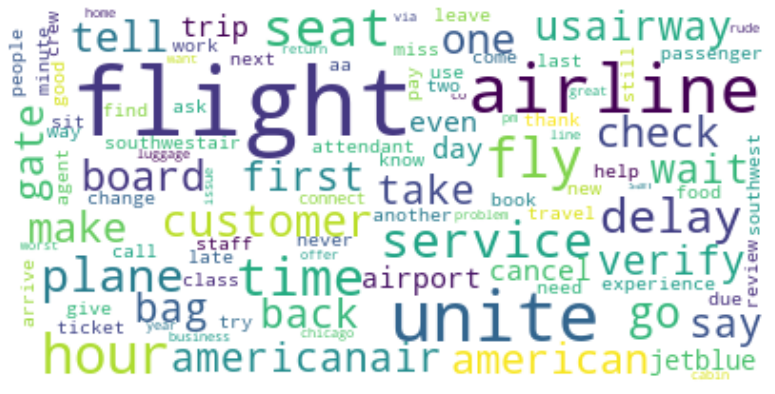

Length of vocab:  17406


In [14]:

# create a batch for test data
# you  can file from github 
# rewrite the path accordingly

import pickle

final_test_data = []
final_test_labels = []
unitedAir = pickle.load(open("/home/unitedAir.pickle", "rb"))

for item in unitedAir['unitedAir']:
  final_test_data.append("united airlines " + preprocess(item[0]))
  final_test_labels.append(item[1])

virginUS = pickle.load(open("/home/virginUS.pickle", "rb"))

for item in virginUS['virginUS']:
  final_test_data.append("virginamerica " + preprocess(item[0]))
  final_test_labels.append(item[1])

southwest = pickle.load(open("/home/southwestAir.pickle", "rb"))

for item in southwest['southwestAir']:
  final_test_data.append("southwestair" + preprocess(item[0]))
  final_test_labels.append(item[1])

americanAir = pickle.load(open("/home/americanAir.pickle", "rb"))


for item in americanAir['americanAir']:
  final_test_data.append("americanair" + preprocess(item[0]))
  final_test_labels.append(item[1])


print(len(preprocessed))
vocab_data = []


for d in preprocessed:
  vocab_data.append(d)

for d in final_test_data:
  vocab_data.append(d)


vocab = create_vocab(vocab_data, True)
print("Length of vocab: ", len(vocab))

In [15]:
# create test_loader

test_indices = []
for i in range(6919):
  test_indices.append(i)
test_loader = create_data_loader(final_test_data, final_test_labels, test_indices, 32, False)
print(len(test_loader))

216


In [16]:

from sklearn.model_selection import StratifiedShuffleSplit

x = int(len(df) * 0.70)
print(x)

vocab_train = {}
c = 0
for item in vocab.items():
  vocab_train[item[0]] = item[1]
  c += 1
  if c == x:
    break

# 70: 30 ratio for train and validation data
train_size =  int(0.7 * len(df['label']))

sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=int(0.3 * len(df['label'])) , random_state=5)
train_indices, valid_indices = next(sss.split(df['text'], df['label']))
train_loader = create_data_loader(preprocessed, df['label'], train_indices,32, True)
val_loader = create_data_loader(preprocessed, df['label'], valid_indices, 32, False)



10248


## Defining our Performance Metrics

In [17]:
import numpy as np

In [18]:
from sklearn.metrics import f1_score

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import sklearn

def f1_score_func(preds, labels):
    print(preds)
    #preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #print(preds_flat)
    
    #return f1_score(labels, preds, average='weighted')
    return sklearn.metrics.f1_score(labels_flat, preds, average='weighted')

In [20]:
def accuracy_score_func(preds, labels):
    #preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return sklearn.metrics.accuracy_score(labels_flat, preds)


In [21]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #preds_flat = np.argmax(preds, axis=1).flatten()
    #labels_flat = labels.flatten()
    preds_flat = preds
    labels_flat = labels

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [22]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
import torch
import torch.nn.functional as F
epochs = 50
batch_size = 32

# using word embedding from word2vec 
import gensim
from gensim.models import keyedvectors, Word2Vec
from keras.preprocessing.text import Tokenizer

model_word2vec = Word2Vec(vocab)
word2vec = model_word2vec.wv

embedding_matrix = np.zeros((len(vocab) + 1, 512))

tokenizerX = Tokenizer()
tokenizerX.fit_on_texts(vocab_data)
word_index = tokenizerX.word_index

for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)

embedding_matrix = torch.Tensor(embedding_matrix)
print(embedding_matrix.shape)

vocab_size = len(vocab)
model = LstmTextClassifier(len(vocab)+1, embedding_matrix, embed_size=512, lstm_size=1024, dense_size=512, output_size=3, lstm_layers=4, dropout=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)
#import torch
torch.cuda.empty_cache()

optimizer = AdamW(model.parameters(),
                  lr=1e-5, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_loader)*epochs)
criterion = nn.NLLLoss()

torch.Size([17407, 512])
cuda


In [187]:
loss_l1 = nn.L1Loss()
import torch
criterion = torch.nn.CrossEntropyLoss()


# for evaluation on validation and testing data
def evaluate(loader):

    model.eval()
    
    loss_val_total = 0
    predictions = []
    true_vals = []
    loss_tmp, loss_cnt = 0, 0
    y_pred_tmp, y_truth_tmp, flight_name, date = [], [], [], []
    hidden = model.init_hidden(batch_size) 
    
    with torch.no_grad():  
      for i,batch in enumerate(loader):
          
          text_batch, label = batch
          #print(len(text_batch))
          fn = []
          dd = []
          for te in text_batch:
            dd.append(te.split(" ")[0])
            fn.append(te.split(" ")[1])
          date.append(dd)
          flight_name.append(fn)

          text_batch = tokenizer_lstm(text_batch, vocab, 128, padding='left').transpose(1,0).to(device)
          #print(text_batch)
          labels = torch.tensor(label, dtype=torch.int64).to(device)

          # Creating new variables for the hidden state to avoid backprop entire training history
          hidden = tuple([each.data for each in hidden])
          for each in hidden:
            each.to(device)

          # Get output and hidden state from the model, calculate the loss
          logits, hidden = model(text_batch, hidden)
          loss = criterion(logits, labels)
          #loss = loss_l1(logits, labels)

          loss_val_total += loss.item()
          loss_cnt += 1

          y_pred_tmp.append(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
          y_truth_tmp.append(labels.cpu().numpy())

      loss_val_avg = loss_val_total/len(val_loader) 
      
      predictions = np.concatenate(y_pred_tmp, axis=0)
      true_vals = np.concatenate(y_truth_tmp, axis=0)
            
    return loss_val_avg, predictions, true_vals, flight_name, date

In [189]:
import matplotlib.pyplot as plt
loss_l1 = nn.L1Loss()
xx = []
yy = []
line = []

f1_score = []
accuracy_score = []


import torch
criterion = torch.nn.CrossEntropyLoss()


def train_LSTM_model(model):
  for epoch in tqdm(range(1, epochs+1)):
      
      model.train()
      
      loss_train_total = 0
      loss_tmp, loss_cnt = 0, 0
      y_pred_tmp, y_truth_tmp = [], []
      hidden = model.init_hidden(batch_size) 

      progress_bar = tqdm(train_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
      for i,batch in enumerate(progress_bar):
          text_batch, label = batch
          model.zero_grad()

          text_batch = tokenizer_lstm(text_batch, vocab, 50, padding="left").transpose(1,0).to(device)
          labels = torch.tensor(label, dtype=torch.int64).to(device)

          # Creating new variables for the hidden state to avoid backprop entire training history
          hidden = tuple([each.data for each in hidden])
          for each in hidden:
              each.to(device)

          # Get output and hidden state from the model, calculate the loss
          logits, hidden = model(text_batch, hidden)        
          loss = criterion(logits, labels) 

          y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
          y_truth_tmp.extend(labels.cpu().numpy())

          # Training Loss
          loss_train_total += loss.item()
          loss_cnt += 1
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()
          
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
      
          
      tqdm.write(f'\nEpoch {epoch}')
      
      loss_train_avg = loss_train_total/len(train_loader)            
      tqdm.write(f'Training loss: {loss_train_avg}')
      
      val_loss, predictions, true_vals, _, _ = evaluate(val_loader)
      val_f1 = f1_score_func(predictions, true_vals)
      val_acc =  accuracy_score_func(predictions, true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score (Weighted): {val_f1}')
      xx.append(loss_train_avg)
      yy.append(val_loss)
      f1_score.append(val_f1)
      accuracy_score.append(val_acc)
      line.append(epoch)
  
train_LSTM_model(model)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




Epoch 1
Training loss: 0.8937254333868623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[2 0 2 ... 2 2 2]
Validation loss: 0.7984674129172833
F1 Score (Weighted): 0.5428702844996997



Epoch 2
Training loss: 0.768442402780056
[2 1 0 ... 0 1 2]
Validation loss: 0.7502924939141656
F1 Score (Weighted): 0.6238341150987351



Epoch 3
Training loss: 0.7240903439000249
[0 1 2 ... 2 1 2]
Validation loss: 0.7167941964890835
F1 Score (Weighted): 0.6465249549312189



Epoch 4
Training loss: 0.6947713738307357
[1 1 0 ... 2 1 2]
Validation loss: 0.6948410359612347
F1 Score (Weighted): 0.6701953991796702



Epoch 5
Training loss: 0.6737695354968309
[1 1 0 ... 0 1 2]
Validation loss: 0.6998787246046275
F1 Score (Weighted): 0.6798425620824899



Epoch 6
Training loss: 0.6563312450423837
[1 1 0 ... 0 1 2]
Validation loss: 0.6742967277982809
F1 Score (Weighted): 0.7027671064493842



Epoch 7
Training loss: 0.639711700566113
[1 1 0 ... 2 1 2]
Validation loss: 0.6638618720708972
F1 Score (Weighted): 0.708750429102833



Epoch 8
Training loss: 0.6256531143561006
[1 1 0 ... 2 1 2]
Validation loss: 0.6568076358224354
F1 Score (Weighted): 0.7157197653605805



Epoch 9
Training loss: 0.6079663778655231
[1 1 2 ... 2 1 2]
Validation loss: 0.6657342138516642
F1 Score (Weighted): 0.7111850137315386



Epoch 10
Training loss: 0.5976325490511953
[1 1 2 ... 2 1 2]
Validation loss: 0.6548414817691719
F1 Score (Weighted): 0.7218009672092832



Epoch 11
Training loss: 0.5784929418005049
[1 1 0 ... 2 1 2]
Validation loss: 0.6500066357807521
F1 Score (Weighted): 0.728493873402547



Epoch 12
Training loss: 0.5665637956932187
[1 1 2 ... 2 1 2]
Validation loss: 0.6402385421913036
F1 Score (Weighted): 0.7263478227604365



Epoch 13
Training loss: 0.5529841428156942
[1 1 2 ... 2 1 2]
Validation loss: 0.6425091900529653
F1 Score (Weighted): 0.7229545889704342



Epoch 14
Training loss: 0.5395519266370684
[1 1 2 ... 2 1 2]
Validation loss: 0.636006767079778
F1 Score (Weighted): 0.7320062639621101



Epoch 15
Training loss: 0.5270209962036461
[1 1 2 ... 2 1 2]
Validation loss: 0.6481213449996753
F1 Score (Weighted): 0.729333725587832



Epoch 16
Training loss: 0.5159745784476399
[1 1 2 ... 2 1 2]
Validation loss: 0.673761743698677
F1 Score (Weighted): 0.7321955826053965



Epoch 17
Training loss: 0.4978232530411333
[1 1 2 ... 2 1 2]
Validation loss: 0.6631893176231941
F1 Score (Weighted): 0.7352112290505091



Epoch 18
Training loss: 0.4875525870360434
[1 1 2 ... 2 1 2]
Validation loss: 0.6587540964140509
F1 Score (Weighted): 0.7339123411035102



Epoch 19
Training loss: 0.4742397549562156
[1 1 2 ... 2 1 2]
Validation loss: 0.6736076217498222
F1 Score (Weighted): 0.7339873843118313



Epoch 20
Training loss: 0.4616186653263867
[1 1 2 ... 2 1 2]
Validation loss: 0.6799032548918341
F1 Score (Weighted): 0.7357924442784147



Epoch 21
Training loss: 0.45546834212727844
[1 1 2 ... 2 1 2]
Validation loss: 0.672442251530877
F1 Score (Weighted): 0.7313492641127765



Epoch 22
Training loss: 0.4355538501637056
[1 1 2 ... 2 1 2]
Validation loss: 0.7269313135286317
F1 Score (Weighted): 0.7371745493798029



Epoch 23
Training loss: 0.4238331252709031
[1 1 2 ... 2 1 2]
Validation loss: 0.7177534808207603
F1 Score (Weighted): 0.7370962941768755



Epoch 24
Training loss: 0.4078767579980195
[1 1 2 ... 2 1 2]
Validation loss: 0.7645248973021542
F1 Score (Weighted): 0.7415345229914294



Epoch 25
Training loss: 0.3917319078464061
[1 1 2 ... 2 1 2]
Validation loss: 0.7416152184026955
F1 Score (Weighted): 0.7310732445929949



Epoch 26
Training loss: 0.38221786692738535
[1 1 2 ... 2 1 2]
Validation loss: 0.788615905237894
F1 Score (Weighted): 0.7435095953905748



Epoch 27
Training loss: 0.36866156293544916
[0 1 2 ... 2 1 2]
Validation loss: 0.8411010608185817
F1 Score (Weighted): 0.7370469825834052



Epoch 28
Training loss: 0.35798673739191145
[0 1 2 ... 2 1 2]
Validation loss: 0.8570428843045756
F1 Score (Weighted): 0.7432905762548766



Epoch 29
Training loss: 0.3429694067221135
[0 1 2 ... 2 1 2]
Validation loss: 0.8332506594431661
F1 Score (Weighted): 0.7401393446332543



Epoch 30
Training loss: 0.3362865867791697
[0 1 2 ... 2 1 2]
Validation loss: 0.9434604717649683
F1 Score (Weighted): 0.7368812311318438



Epoch 31
Training loss: 0.3225514138583094
[0 1 2 ... 2 1 2]
Validation loss: 0.9869087777868675
F1 Score (Weighted): 0.7384666240920866



Epoch 32
Training loss: 0.31245213395450266
[0 1 2 ... 2 1 2]
Validation loss: 0.9140932027005801
F1 Score (Weighted): 0.7388156910964657



Epoch 33
Training loss: 0.3002746300539002
[1 1 2 ... 2 1 2]
Validation loss: 0.907110280146564
F1 Score (Weighted): 0.7435818965911941



Epoch 34
Training loss: 0.29324527005665
[1 1 2 ... 2 1 2]
Validation loss: 0.9266867609354701
F1 Score (Weighted): 0.7361474750507088



Epoch 35
Training loss: 0.2897998382337391
[0 1 2 ... 2 1 2]
Validation loss: 0.961973584046329
F1 Score (Weighted): 0.7449782049699797



Epoch 36
Training loss: 0.27098944678436965
[0 1 2 ... 2 1 2]
Validation loss: 1.0065253846836786
F1 Score (Weighted): 0.745043947676124



Epoch 37
Training loss: 0.26395582370460036
[0 1 2 ... 2 1 2]
Validation loss: 0.9908233228391105
F1 Score (Weighted): 0.7376349898173792



Epoch 38
Training loss: 0.26243250812403857
[0 1 2 ... 2 1 2]
Validation loss: 1.0424909779842753
F1 Score (Weighted): 0.745625504823498



Epoch 39
Training loss: 0.24886626147199423
[0 1 2 ... 2 1 2]
Validation loss: 1.0548743692627789
F1 Score (Weighted): 0.7436623047496181



Epoch 40
Training loss: 0.2505026557599194
[0 1 2 ... 2 1 2]
Validation loss: 1.171467458788496
F1 Score (Weighted): 0.7465801015349789



Epoch 41
Training loss: 0.23991937197279184
[0 1 2 ... 2 1 2]
Validation loss: 1.1010444795128203
F1 Score (Weighted): 0.7422830593560574



Epoch 42
Training loss: 0.2305459412978962
[0 1 2 ... 2 1 2]
Validation loss: 1.1041217922729298
F1 Score (Weighted): 0.7390805702628267



Epoch 43
Training loss: 0.22788074899581262
[0 1 2 ... 2 1 2]
Validation loss: 1.1290220994583882
F1 Score (Weighted): 0.7381110128645355



Epoch 44
Training loss: 0.22304753665812313
[0 1 2 ... 2 1 2]
Validation loss: 1.1241368627461203
F1 Score (Weighted): 0.7402345996258677



Epoch 45
Training loss: 0.21662381627829747
[0 1 2 ... 2 1 2]
Validation loss: 1.1820450788431793
F1 Score (Weighted): 0.7464074486101606



Epoch 46
Training loss: 0.2152480003540404
[0 1 2 ... 2 1 2]
Validation loss: 1.2085911208478204
F1 Score (Weighted): 0.746118062238519



Epoch 47
Training loss: 0.20701264292001725
[0 1 2 ... 2 1 2]
Validation loss: 1.1912391161831626
F1 Score (Weighted): 0.7452134085362413



Epoch 48
Training loss: 0.20708726270240732
[0 1 2 ... 2 1 2]
Validation loss: 1.2363106101533792
F1 Score (Weighted): 0.7466412254175451



Epoch 49
Training loss: 0.20318837750819513
[0 1 2 ... 2 1 2]
Validation loss: 1.2241180223705124
F1 Score (Weighted): 0.7469710165061967



Epoch 50
Training loss: 0.2026473736972548
[0 1 2 ... 2 1 2]
Validation loss: 1.2394108457939468
F1 Score (Weighted): 0.7464700465893443



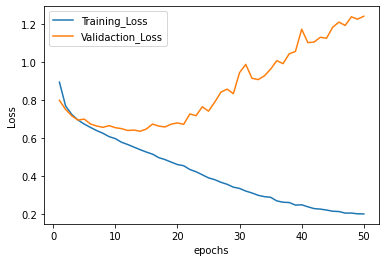

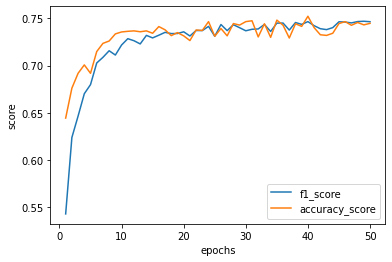

In [190]:
import matplotlib.pyplot as plt
plot1 = plt.figure(1)
plt.plot(line, xx, label = "Training_Loss")
plt.plot(line, yy, label = "Validaction_Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plot2 = plt.figure(2)
plt.plot(line, f1_score, label = "f1_score")
plt.plot(line, accuracy_score, label = "accuracy_score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

In [191]:

_, predictions, true_vals, flight_names , date = evaluate(val_loader)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [193]:
accuracy_per_class(predictions, true_vals)

Class: neutral
Accuracy: 512/929

Class: positive
Accuracy: 430/709

Class: negative
Accuracy: 2323/2746



In [2]:
import pickle

import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=['Scores', 'Neutral', 'Positive', 'Negative', 'total'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[['Neutral', 'Positive', 'Negative'],[512, 96, 321], # 1st column
                       [175, 430, 104], [321, 104, 2323], [929, 709, 2746]], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=500, height=300)
fig.show()